# Lab 16 Assignment 3 - Group Assignment

When creating ML models, the concept of efficiency has three sides:
1. The time dedicated by the analyst to build the model
2. The computer time and resources needed by the final model
3. The accuracy of the final model

Efficiency is a combination of all

In this assignment, you are asked to be efficient. Spark is the best tool to build models over massive datasets

If you need to create Spark+Python Machine Learning models that "run fast" on the  cluster, you must avoid using Python code or working with RRD+python. Try to use  the already existing methods that do what you need (do not reinvent the wheel).

Therefore try to use the implemented object+methods inside the Spark SQL and ML modules. They are very fast, because it is compiled Java/Scala code. Try to use: DataFrames, Feature Transfomers, Estimators, Pipelines, GridSearch, CV, ...

For this assignment, you are asked to create a classification model that:
1. Uses the variables in the dataset (train.csv) to predict label "loan_status"
2. Write a python scripts that:
    - Reads the "train.csv" and "test.csv" files, transform and select variables as you wish.
    - Train/fit your model using the "train.csv".
    - Predict your model on the "test.csv" ( you should generate a file with your predictions).
    - I will use a different test dataset (with the true loan_status).

Your work will be evaluated under the following scoring schema
- (40%) ETL process
- (40%) Model train process
- (10%) Code Readability 
- (10%) AUC on the test set (at least 50%)

Enjoy it and best of luck!!


This Assignment is based on kaggle competition https://www.kaggle.com/c/loan-default-prediction from where a sub-dataset has been taken.

### File descriptions
**train.csv** - the training set (to use for building a model)

**test.csv** - the test set (to use for applying predictings)

**sample_submission.csv** - a template for the submission file

### Data Description (also contained in LendingClub_DataDescription.csv)
**ID**: A unique LC assigned ID for the loan listing.

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**: Current status of the loan (**Target**: 1 = Charged Off, 0 = Fully Paid).

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate**: Interest Rate on the loan.

**installment**: The monthly payment owed by the borrower if the loan originates.

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership**: The home ownership status provided by the borrower during registration. Our values are: OTHER/NONE, MORTGAGE, OWN, RENT.

**annual_inc**: The self-reported annual income provided by the borrower during registration.

**purpose**: A category provided by the borrower for the loan request.

**title**: The loan title provided by the borrower.

**STATE**: The state provided by the borrower in the loan application.

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

**revol_bal**: Total credit revolving balance.  revolve a balance -- that is, not pay it off at the end of the month 

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_pymnt**: Indicates total payment at the end of the loan.

In [2]:
import os
import sys

os.environ['SPARK_HOME'] = "C:\\spark-2.3.2-bin-hadoop2.7\\"

# Create a variable for our root path
SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path. Please check your installation
#to make sure that these zip files actually exist. The names might change
#as versions change.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.7-src.zip"))

#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession

#Create a Spark Session
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("MiPrimer") \
    .config("spark.executor.memory", "6g") \
    .config("spark.cores.max","4") \
    .getOrCreate()


#Get the Spark Context from Spark Session    
sc = spark.sparkContext

In [3]:
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.ml.feature import Normalizer, Imputer, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.param import Params
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel, RandomForestClassifier,GBTClassifier

### 1. Read the files into a Dataframes and show them

In [4]:
loanDF = spark.read.format('csv') \
           .option("inferSchema", "true") \
           .option("header","true")\
           .option("delimiter", ";") \
           .load('../data/train.csv') 

testDF = spark.read.format('csv') \
            .option("inferSchema", "true") \
            .option("header","true")\
            .option("delimiter", ";") \
            .load('../data/test.csv') 

### 2. Analizing null values, cross tables distribution and covariances

#### 2.1. Null values

In [5]:
loanDF_empty=loanDF.select([f.count(f.when(col(c).isNull() | f.isnan(c), c)).alias(c) for c in loanDF.columns])
print('Total number of rows = {0}. Total number of missing values, per column:'.format(loanDF.count()))
loanDF_empty.toPandas()

Total number of rows = 29755. Total number of missing values, per column:


,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,0,0,0,0,0,0,0,0,1229,1238,1239,1239,1239,1275,1239,0


#### 2.2. Cross table distribution

In [6]:
cross_list=[x for x in loanDF.columns if x in ['term','emp_length','home_ownership','STATE']]
[loanDF.crosstab(c,'loan_status').show() for c in cross_list]

+----------------+-----+----+
|term_loan_status|    0|   1|
+----------------+-----+----+
|       60 months| 6203|1846|
|       36 months|19327|2379|
+----------------+-----+----+

+----------------------+----+----+
|emp_length_loan_status|   0|   1|
+----------------------+----+----+
|               5 years|2149| 348|
|               6 years|1435| 235|
|               3 years|2675| 387|
|               8 years| 950| 160|
|                1 year|2097| 343|
|              < 1 year|2968| 478|
|               9 years| 820| 120|
|                   n/a| 622| 170|
|               4 years|2245| 346|
|             10+ years|5599|1006|
|               7 years|1127| 205|
|               2 years|2843| 427|
+----------------------+----+----+

+--------------------------+-----+----+
|home_ownership_loan_status|    0|   1|
+--------------------------+-----+----+
|                     OTHER|   60|   9|
|                       OWN| 1950| 322|
|                  MORTGAGE|11514|1774|
|                 

[None, None, None, None]

#### ETL summary

You should explain how you are going to clean and prepare the data  
1. Deal with data types  
2. Create ratio  
3. Drop fiels  
4. Impute numerical missing values with median
5. Normalize numerical values  
6. Convert categories into index  
7. Convert index into onehotencoding


### 2.1 Spark code about the one explained in "ETL Summary"

In [7]:
#OWN CONSTRUCTED FUNCTIONS FOR PIPELINE

#data types
def fix_data_types(data):
    data=data.withColumn('int_rate', col('int_rate').substr(1, 4))\
             .withColumn("int_rate", col("int_rate").cast('float'))\
             .withColumn('revol_util', col('revol_util').substr(1, 4))\
             .withColumn("revol_util", col("revol_util").cast('float'))\
             .withColumn("delinq_2yrs", col("delinq_2yrs").cast('float'))\
             .withColumn("revol_bal", col("revol_bal").cast('float'))
    return data

def create_ratio(data):
    data=data.withColumn('r_ins_minc',(data['installment']/(data['annual_inc']/12)))
    return data

def drop_fields(data):
    data=data.drop('ID','title','home_ownership')
    return data

def update_df(data, operations):
    for ops in operations:
        data=ops(data)
    return data    

### 2.2 Spark code about the transformations you apply to the variables

In [8]:
#ml lib INTEGRATED FUNCTIONS FOR PIPELINE
stages=[]

#Missings values

empty_values=["delinq_2yrs","revol_bal","revol_util","total_pymnt"]
null_imputer=Imputer()\
        .setStrategy('median')\
        .setInputCols(empty_values)\
        .setOutputCols(empty_values)\


stages.append(null_imputer)

#Normalize?????

#Convert categories to numbers
convert_list=['term','emp_length','STATE','purpose','loan_status']
for val in convert_list:
    if val=='loan_status_index':
        string_to_index = StringIndexer(inputCol = val, outputCol = val+'_index')
        stages.append(string_to_index)
    else:
        string_to_index = StringIndexer(inputCol = val, outputCol = val+'_index',handleInvalid='keep')
        stages.append(string_to_index)
    
#One hot encoding
encoder = encoder = OneHotEncoderEstimator(inputCols=["term_index",'purpose_index','STATE_index'],
                                           outputCols=["term_enc",'purpose_enc','STATE_enc'])
stages.append(encoder)

### 2.3 Code to assemble the variables to a numerical vector (VectorAssembler)

In [9]:
assembler = VectorAssembler(inputCols=['loan_amnt','installment', 'annual_inc', 'delinq_2yrs', 'revol_bal', 'revol_util',\
                                        'total_pymnt','r_ins_minc','term_index','term_enc','purpose_enc', 'STATE_enc'],\
                            outputCol='features')
stages.append(assembler)

#### Make sure stages contain all required steps

In [10]:
stages

[Imputer_4e4d8cdce88ce1036291,
 StringIndexer_4392a8aa3705a82fc9fa,
 StringIndexer_4a5fabb2408a0f7a4b0b,
 StringIndexer_4e4ea70855aa6f56e3ed,
 StringIndexer_481bafbcd64f09ad96eb,
 StringIndexer_4dae86dd8696a5dd30df,
 OneHotEncoderEstimator_41da9cb96fbce02665f2,
 VectorAssembler_402c9760c948bd16628e]

### 2.4 Create Pipeline for train and test data

In [11]:
preprocessing=[fix_data_types,create_ratio,drop_fields]
pipeline=Pipeline(stages=stages)

trainDF=update_df(loanDF,preprocessing)
model=pipeline.fit(trainDF)
trainDF1=model.transform(trainDF)

testDF=update_df(testDF,preprocessing)
testDF1=model.transform(testDF)

After all the steps applied in previous box, the **train and test dataset are cleaned and prepared** so that the models can be applied on them.

In [12]:
trainDF1.toPandas().head(10)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,revol_bal,...,r_ins_minc,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,purpose_enc,STATE_enc,features
0,2500,60 months,15.20,59.83,< 1 year,30000.0,car,GA,0.0,1687.0,...,0.023932,1.0,1.0,7.0,6.0,1.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(2500.0, 59.83, 30000.0, 0.0, 1687.0, 0.090000..."
1,10000,36 months,13.40,339.31,10+ years,49200.0,other,CA,0.0,5598.0,...,0.082759,0.0,0.0,0.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(10000.0, 339.31, 49200.0, 0.0, 5598.0, 0.2099..."
2,3000,60 months,12.60,67.79,1 year,80000.0,other,OR,0.0,27783.0,...,0.010169,1.0,6.0,24.0,2.0,0.0,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3000.0, 67.79, 80000.0, 0.0, 27783.0, 0.52999..."
3,5000,36 months,7.90,156.46,3 years,36000.0,wedding,AZ,0.0,7963.0,...,0.052153,0.0,3.0,12.0,7.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5000.0, 156.46, 36000.0, 0.0, 7963.0, 0.28000..."
4,7000,60 months,15.90,170.08,8 years,47004.0,debt_consolidation,NC,0.0,17726.0,...,0.043421,1.0,9.0,15.0,0.0,0.0,"(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(7000.0, 170.08, 47004.0, 0.0, 17726.0, 0.8500..."
5,3000,36 months,18.60,109.43,9 years,48000.0,car,CA,0.0,8221.0,...,0.027358,0.0,10.0,0.0,6.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3000.0, 109.43, 48000.0, 0.0, 8221.0, 0.87000..."
6,5375,60 months,12.60,121.45,< 1 year,15000.0,other,TX,0.0,9279.0,...,0.097160,1.0,1.0,3.0,2.0,1.0,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5375.0, 121.45, 15000.0, 0.0, 9279.0, 0.36000..."
7,6500,60 months,14.60,153.45,5 years,72000.0,debt_consolidation,AZ,0.0,4032.0,...,0.025575,1.0,5.0,12.0,0.0,0.0,"(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6500.0, 153.45, 72000.0, 0.0, 4032.0, 0.20000..."
8,12000,36 months,12.60,402.54,10+ years,75000.0,debt_consolidation,CA,0.0,23336.0,...,0.064406,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(12000.0, 402.54, 75000.0, 0.0, 23336.0, 0.670..."
9,3000,36 months,9.91,96.68,3 years,15000.0,credit_card,IL,0.0,7323.0,...,0.077344,0.0,3.0,5.0,1.0,0.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(3000.0, 96.68, 15000.0, 0.0, 7323.0, 0.430000..."


In [13]:
testDF1.toPandas().head(10)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,revol_bal,...,r_ins_minc,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,purpose_enc,STATE_enc,features
0,5000,36 months,10.600000,162.87,10+ years,24000.0,credit_card,AZ,0.0,13648.0,...,0.081435,0.0,0.0,12.0,1.0,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5000.0, 162.87, 24000.0, 0.0, 13648.0, 0.8399..."
1,2400,36 months,15.900000,84.33,10+ years,12252.0,small_business,IL,0.0,2956.0,...,0.082595,0.0,0.0,5.0,5.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2400.0, 84.33, 12252.0, 0.0, 2956.0, 0.990000..."
2,5600,60 months,21.200001,152.39,4 years,40000.0,small_business,CA,0.0,5210.0,...,0.045717,1.0,4.0,0.0,5.0,1.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5600.0, 152.39, 40000.0, 0.0, 5210.0, 0.33000..."
3,9000,36 months,13.400000,305.38,< 1 year,30000.0,debt_consolidation,VA,0.0,10452.0,...,0.122152,0.0,1.0,8.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(9000.0, 305.38, 30000.0, 0.0, 10452.0, 0.9200..."
4,10000,36 months,10.600000,325.74,3 years,100000.0,other,CA,0.0,11997.0,...,0.039089,0.0,3.0,0.0,2.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(10000.0, 325.74, 100000.0, 0.0, 11997.0, 0.56..."
5,3600,36 months,6.030000,109.57,10+ years,110000.0,major_purchase,CT,0.0,22836.0,...,0.011953,0.0,0.0,16.0,4.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3600.0, 109.57, 110000.0, 0.0, 22836.0, 0.159..."
6,15000,36 months,9.910000,483.38,2 years,92000.0,credit_card,IL,0.0,13707.0,...,0.063050,0.0,2.0,5.0,1.0,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(15000.0, 483.38, 92000.0, 0.0, 13707.0, 0.939..."
7,15000,36 months,14.200000,514.64,9 years,60000.0,debt_consolidation,NY,0.0,5872.0,...,0.102928,0.0,10.0,1.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(15000.0, 514.64, 60000.0, 0.0, 5872.0, 0.5799..."
8,4000,36 months,11.700000,132.31,10+ years,106000.0,debt_consolidation,FL,1.0,6110.0,...,0.014978,0.0,0.0,2.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4000.0, 132.31, 106000.0, 1.0, 6110.0, 0.3799..."
9,4375,36 months,7.510000,136.11,7 years,17108.0,debt_consolidation,NY,0.0,11210.0,...,0.095471,0.0,8.0,1.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4375.0, 136.11, 17108.0, 0.0, 11210.0, 0.8700..."


#### Split train set into training and validation

In [14]:
(trainingData, validationData) = trainDF1.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(validationData.count())

20882
8873


# ***************   HASTA AQUÍ PERFECTO  **************************

### 3. Logistic Regresion Model

### 3.1 Write a function "metrics" which has a LogisticRegressionModel.summary as input attribute and produces an output of: 
1. Area under ROC
2. False Positive Rate By Label
3. True Positive Rate By Label
4. Precision By Label
5. Recall By Label
6. fMeasure By Label
7. Accuracy
8. False Positive Rate
9. True Positive Rate
10. fMeasure
11. Precision
12. Recall

In [15]:
#The fitted model from a Pipeline is a PipelineModel
def metrics(trainingSummary):
    '''This function takes a model that has been fitted (logisticregressionModel) and extracts all metrics'''
    #print("Area under ROC: "+str(trainingSummary.areaUnderROC))
    print("False Positive Rate: "+str(trainingSummary.weightedFalsePositiveRate))
    print("True Positive Rate: "+str(trainingSummary.weightedTruePositiveRate))
    print("Precision: "+str(trainingSummary.weightedPrecision))
    print("Recall: "+str(trainingSummary.weightedRecall))
    print("F measure: "+str(trainingSummary.weightedFMeasure))
    print("Accuracy: "+str(trainingSummary.accuracy))


### 3.2 Apply a Logistic Regresion Base Model and show the metrics by the function above

In [16]:
lr = LogisticRegression() \
        .setFeaturesCol("features") \
        .setLabelCol("loan_status_index")

lr_model=lr.fit(trainingData)
#print(lr_model.explainParams())
metrics(lr_model.summary)

False Positive Rate: 0.32952477410590697
True Positive Rate: 0.939373623216167
Precision: 0.9386810375691577
Recall: 0.939373623216167
F measure: <bound method LogisticRegressionSummary.weightedFMeasure of <pyspark.ml.classification.LogisticRegressionTrainingSummary object at 0x000001F34472D860>>
Accuracy: 0.939373623216167


### 3.2 We are going to try to improve our model:
1. Using a `weight column` in our Logistic Regression Model (Take into account we are working with a unbalanced dataset)
2. Define a `ParamGridBuilder` with `regParam`, `elasticNetParam` and `maxIter` at least
3. Define an `BinaryClassificationEvaluator`
4. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:
1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which are the metrics of the best model (training) in the 5 k-fold runs? (Use the function above)
5. Which is the ROC-AUC on validation dataset?


In [56]:
# Grid Search function
# def lr_GridSearch(estimator):
    
#     ParamGridBuilder()\
#     .baseOn({estimator.labelCol: "loan_status_index"}) \
#     .baseOn([lr.predictionCol, 'p']) \
#     .addGrid(lr.regParam, [1.0, 2.0]) \
#     .addGrid(lr.maxIter, [1, 5]) \
#     .build()


#BinaryClassificationEvaluator
#def evaluator(model_result_on_test):
#    '''This function takes the Accuracy of a fitted model applied on a validation dataset'''
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

print("Area Under ROC: " + str(AUC))

In [23]:
trainingData.toPandas()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,revol_bal,...,r_ins_minc,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,purpose_enc,STATE_enc,features
0,500,36 months,8.070000,15.69,< 1 year,18000.00,other,NY,0.0,0.0,...,0.010460,0.0,1.0,1.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 15.69, 18000.0, 0.0, 0.0, 0.5, 565.025..."
1,500,36 months,9.760000,16.08,7 years,59000.00,other,NY,0.0,65414.0,...,0.003271,0.0,8.0,1.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 16.08, 59000.0, 0.0, 65414.0, 0.469999..."
2,500,36 months,10.700000,16.31,< 1 year,7904.04,vacation,CA,1.0,44.0,...,0.024762,0.0,1.0,0.0,11.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 16.31, 7904.04, 1.0, 44.0, 0.029999999..."
3,500,36 months,11.400000,16.47,< 1 year,19500.00,other,VA,0.0,12229.0,...,0.010135,0.0,1.0,8.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(500.0, 16.47, 19500.0, 0.0, 12229.0, 0.899999..."
4,725,36 months,7.370000,22.51,1 year,12000.00,credit_card,CA,0.0,1814.0,...,0.022510,0.0,6.0,0.0,1.0,0.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(725.0, 22.51, 12000.0, 0.0, 1814.0, 0.0700000..."
5,750,36 months,12.200000,25.02,< 1 year,19000.00,credit_card,CO,0.0,12220.0,...,0.015802,0.0,1.0,14.0,1.0,0.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(750.0, 25.02, 19000.0, 0.0, 12220.0, 0.839999..."
6,1000,36 months,5.420000,30.16,1 year,50400.00,other,CA,0.0,1440.0,...,0.007181,0.0,6.0,0.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 50400.0, 0.0, 1440.0, 0.070000..."
7,1000,36 months,5.420000,30.16,10+ years,62400.00,major_purchase,WI,0.0,22010.0,...,0.005800,0.0,0.0,22.0,4.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 62400.0, 0.0, 22010.0, 0.25, 1..."
8,1000,36 months,5.420000,30.16,n/a,28800.00,car,NJ,0.0,3134.0,...,0.012567,0.0,11.0,4.0,6.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 28800.0, 0.0, 3134.0, 0.050000..."
9,1000,36 months,5.420000,30.16,n/a,50112.00,other,VA,0.0,4461.0,...,0.007222,0.0,11.0,8.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1000.0, 30.16, 50112.0, 0.0, 4461.0, 0.180000..."


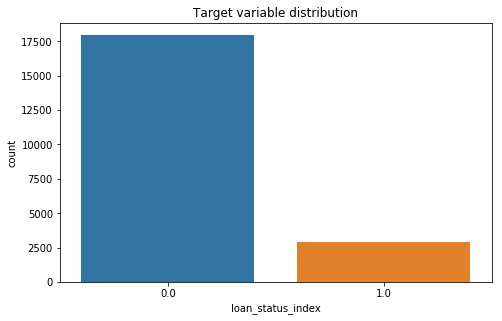

,count,proportion
0,17948,0.859496
1,2934,0.140504


In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df=trainingData.toPandas()
plt.subplots_adjust(hspace=0.4, wspace=0.2,left=0.5, right=1.5,top=1, bottom=0.1)
sns.countplot(df['loan_status_index'])
plt.title('Target variable distribution')
plt.show()

counts, bin_edges = np.histogram(df['loan_status_index'], bins=2)
proportion_loan_status_index=pd.DataFrame(counts,index=[0,1],columns=['count'])
proportion_loan_status_index['proportion']=(proportion_loan_status_index['count']/proportion_loan_status_index['count'].sum())
proportion_loan_status_index

In [38]:
trainingData.count()

20882

In [60]:
def col_weigths (dataset):
    data=dataset.toPandas()
    counts, bin_edges = np.histogram(data['loan_status_index'], bins=2)
    proportion_loan_status_index=pd.DataFrame(counts,index=[0,1],columns=['count'])
    proportion_loan_status_index['proportion']=(proportion_loan_status_index['count']/proportion_loan_status_index['count'].sum())
    proportion_loan_status_index
    
    proportion_zeros=proportion_loan_status_index.loc[0,'count']
    proportion_ones=proportion_loan_status_index.loc[1,'proportion']
    
    balancing_ratio=proportion_zeros/dataset.count()
    print(balancing_ratio,proportion_zeros,dataset.count())
    dataset=dataset.withColumn("classWeights", f.when(dataset.loan_status_index == 1.0,balancing_ratio).otherwise(1-balancing_ratio))
    
    return dataset

In [61]:
prueba=col_weigths(trainingData)


0.8594962168374677 17948 20882


In [62]:
prueba.toPandas()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,revol_bal,...,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,purpose_enc,STATE_enc,features,classWeights
0,500,36 months,8.070000,15.69,< 1 year,18000.00,other,NY,0.0,0.0,...,0.0,1.0,1.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 15.69, 18000.0, 0.0, 0.0, 0.5, 565.025...",0.140504
1,500,36 months,9.760000,16.08,7 years,59000.00,other,NY,0.0,65414.0,...,0.0,8.0,1.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 16.08, 59000.0, 0.0, 65414.0, 0.469999...",0.140504
2,500,36 months,10.700000,16.31,< 1 year,7904.04,vacation,CA,1.0,44.0,...,0.0,1.0,0.0,11.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(500.0, 16.31, 7904.04, 1.0, 44.0, 0.029999999...",0.140504
3,500,36 months,11.400000,16.47,< 1 year,19500.00,other,VA,0.0,12229.0,...,0.0,1.0,8.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(500.0, 16.47, 19500.0, 0.0, 12229.0, 0.899999...",0.140504
4,725,36 months,7.370000,22.51,1 year,12000.00,credit_card,CA,0.0,1814.0,...,0.0,6.0,0.0,1.0,0.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(725.0, 22.51, 12000.0, 0.0, 1814.0, 0.0700000...",0.140504
5,750,36 months,12.200000,25.02,< 1 year,19000.00,credit_card,CO,0.0,12220.0,...,0.0,1.0,14.0,1.0,0.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(750.0, 25.02, 19000.0, 0.0, 12220.0, 0.839999...",0.140504
6,1000,36 months,5.420000,30.16,1 year,50400.00,other,CA,0.0,1440.0,...,0.0,6.0,0.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 50400.0, 0.0, 1440.0, 0.070000...",0.140504
7,1000,36 months,5.420000,30.16,10+ years,62400.00,major_purchase,WI,0.0,22010.0,...,0.0,0.0,22.0,4.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 62400.0, 0.0, 22010.0, 0.25, 1...",0.140504
8,1000,36 months,5.420000,30.16,n/a,28800.00,car,NJ,0.0,3134.0,...,0.0,11.0,4.0,6.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1000.0, 30.16, 28800.0, 0.0, 3134.0, 0.050000...",0.140504
9,1000,36 months,5.420000,30.16,n/a,50112.00,other,VA,0.0,4461.0,...,0.0,11.0,8.0,2.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1000.0, 30.16, 50112.0, 0.0, 4461.0, 0.180000...",0.140504


In [ ]:
lr2= LogisticRegression(featuresCol='features', labelCol="loan_status_index",\
                        weightCol=)#weigth column???
#1. Grid Search
# Adjust these parameters
lr_paramGrid = ParamGridBuilder() \
                .addGrid(lr2.regParam, [2,4]) \
                .addGrid(lr2.elasticNetParam, [4,7]) \
                .addGrid(lr2.maxIter, [2,5]) \
                .build()

print("Param Grid: " + str(paramGrid))


#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation
lr_cv = CrossValidator(estimator=lr2, estimatorParamMaps=lr_paramGrid, evaluator=evaluator)

lr_cvModel = lr_cv.fit(trainingData)
lr_cv_results = lr_cvModel.transform(validationData)


# Before we had 0.9024 and now
print("AUC: " + str(evaluator.evaluate(lr_cv_results)))

# Means of model accuracy
print("Means of metrics: " + str(lr_cv_results.avgMetrics))


### 4. Random Forest Model
1. Define a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [ ]:
#1. Define estimator
rf=RandomForestClassifier(featuresCol='features', labelCol="loan_status_index")

#2. GridSearch
# Adjust these parameters
rf_paramGrid = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [2,4]) \
                .addGrid(rf.numTrees, [4,7]) \
                .addGrid(rf.maxIter, [2,5]) \
                .build()
#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator)

rf_cvModel = rf_cv.fit(trainingData)
rf_cv_results = rf_cvModel.transform(validationData)


# Before we had 0.9024 and now
print("AUC: " + str(evaluator.evaluate(rf_cv_results)))

# Means of model accuracy
print("Means of metrics: " + str(rf_cv_results.avgMetrics))


### 5. Gradient Boosting Model
1. Defining a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least (You can use the above one)
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [ ]:
#1. Define estimator
gb=GBTClassifier(featuresCol='features', labelCol="loan_status_index")

#2. GridSearch
# Adjust these parameters
gb_paramGrid = ParamGridBuilder() \
                .addGrid(gb.maxDepth, [2,4]) \
                .addGrid(gb.numTrees, [4,7]) \
                .addGrid(gb.maxIter, [2,5]) \
                .build()
#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation
gb_cv = CrossValidator(estimator=gb, estimatorParamMaps=gb_paramGrid, evaluator=evaluator)

gb_cvModel = gb_cv.fit(trainingData)
gb_cv_results = gb_cvModel.transform(validationData)


# Before we had 0.9024 and now
print("AUC: " + str(evaluator.evaluate(gb_cv_results)))

# Means of model accuracy
print("Means of metrics: " + str(gb_cv_results.avgMetrics))



### 6. Apply your best model to send the predictions on test

In [ ]:
#When we obtain the results from above, we have to decide what model we choose for the final prediction on the testDF1
bestPipelineModel = cvModel.bestModel
bestPipelineModel.stages

In [155]:
sc.stop()